In [1]:
import torch

from NeuroVisualizer.neuro_aux.AEmodel import UniformAutoencoder

from helper.neuro_viz import get_dataloader_flat

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/crebmann/miniconda3/envs/phate-env/lib/python3.10/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


# Neuro-Visualizer
This notebook creates the loss landscape from the NeuroVisualizer

In [5]:
dataset_name = 'mnist'
run_ids = [
    "run-0011-CNN_mnist_32_0.9776", # No Residual
    "run-0012-CNN_mnist_32_0.9768", # No Residual
]

titles = [
    "SGD, 0.9776",
    "SAM, 0.9768"
]

In [2]:
dataset_name = 'mnist'
run_ids = [
    "run-0013-CNN_mnist_32_0.9797", # Residual
    "run-0014-CNN_mnist_32_0.9744", # Residual
]

titles = [
    "SGD, 0.9797",
    "SAM, 0.9744"
]

In [3]:
# CNN x CIFAR 10 
dataset_name = 'cifar10'

run_ids = [
    "run-0017-CNN_cifar10_128_0.8072",  # Seed 42, SAM
    "run-0019-CNN_cifar10_128_0.8487",  # Seed 42
    "run-0021-CNN_cifar10_128_0.8054",  # Seed 11, SAM
    "run-0023-CNN_cifar10_128_0.8509",  # Seed 11
    "run-0025-CNN_cifar10_128_0.8062",
    "run-0027-CNN_cifar10_128_0.8503"
]

titles = [
    "Seed 42, SAM, 0.8072",
    "Seed 42, SGD, 0.8487",
    "Seed 11, SAM, 0.8054",
    "Seed 11, SGD, 0.8509",
    "Seed 6, SAM, 0.8062",
    "Seed 6, SGD, 0.8503",
]

In [4]:
# CNN Residual x CIFAR 10 
dataset_name = 'cifar10'

run_ids = [
    "run-0016-CNN_cifar10_128_0.8093",  # Seed 42, SAM, Residual
    "run-0018-CNN_cifar10_128_0.8499",  # Seed 42, Residual
    "run-0020-CNN_cifar10_128_0.8079",  # Seed 11, SAM, Residual
    "run-0022-CNN_cifar10_128_0.8519",  # Seed 11, Residual
    "run-0024-CNN_cifar10_128_0.8062",
    "run-0026-CNN_cifar10_128_0.8504"
]

titles = [
    "Seed 42, SAM, Residual 0.8093",
    "Seed 42, SGD, Residual 0.8499",
    "Seed 11, SAM, Residual 0.8079",
    "Seed 11, SGD, Residual 0.8519",
    "Seed 6, SAM, Residual 0.0.8062",
    "Seed 6, SGD, Residual 0.8504",
]

### Load Paths

In [3]:
from helper.visualization import Run

runs = []
for run_id in run_ids:
    runs.append(Run(run_id, dataset_name))

In [4]:
for run in runs:
    print(run.results["train_config"])

CNN|opt=SGD|lr=0.001|wd=0.05|sam=False
CNN|opt=SAMSGD|lr=0.001|wd=0.05|sam=True


In [5]:
pt_files_per_run = [run.get_pt_files() for run in runs]

trainings/run-0013-CNN has 13 files
Found 13 checkpoint files.
trainings/run-0014-CNN has 13 files
Found 13 checkpoint files.


In [6]:
vis_id = ' x '.join([run.results["ll_flattened_weights_dir"] for run in runs])
model_file = f'ae_models/{vis_id}.pt'
print(model_file)

#model_file = "ae_models/run-0016-CNN x run-0018-CNN x run-0020-CNN x run-0022-CNN x run-0024-CNN x run-0026-CNN.pt"

ae_models/run-0013-CNN x run-0014-CNN.pt


In [7]:
pt_files_per_run

[['trainings/run-0013-CNN/model-0.pt',
  'trainings/run-0013-CNN/model-1.pt',
  'trainings/run-0013-CNN/model-2.pt',
  'trainings/run-0013-CNN/model-3.pt',
  'trainings/run-0013-CNN/model-4.pt',
  'trainings/run-0013-CNN/model-5.pt',
  'trainings/run-0013-CNN/model-6.pt',
  'trainings/run-0013-CNN/model-7.pt',
  'trainings/run-0013-CNN/model-8.pt',
  'trainings/run-0013-CNN/model-9.pt',
  'trainings/run-0013-CNN/model-10.pt',
  'trainings/run-0013-CNN/model-11.pt',
  'trainings/run-0013-CNN/model-12.pt'],
 ['trainings/run-0014-CNN/model-0.pt',
  'trainings/run-0014-CNN/model-1.pt',
  'trainings/run-0014-CNN/model-2.pt',
  'trainings/run-0014-CNN/model-3.pt',
  'trainings/run-0014-CNN/model-4.pt',
  'trainings/run-0014-CNN/model-5.pt',
  'trainings/run-0014-CNN/model-6.pt',
  'trainings/run-0014-CNN/model-7.pt',
  'trainings/run-0014-CNN/model-8.pt',
  'trainings/run-0014-CNN/model-9.pt',
  'trainings/run-0014-CNN/model-10.pt',
  'trainings/run-0014-CNN/model-11.pt',
  'trainings/run-00

In [8]:
# Filter for final epochs only

# pt_files_per_run = []

# for run in runs:
#     min_loss = min(run.results["val_losses"])
#     max_visualize = min_loss * 1.1
#     print(max_visualize)
#     # Find in run.results["val_losses"] idx where val losses is first below max_visualize
#     idx = next((i for i, v in enumerate(run.results["val_losses"]) if v <= max_visualize), None)
#     pt_files_per_run.append(run.get_pt_files()[idx:])
#
# pt_files_per_run

## Train AE Model
Run this part to train an AE-Model

In [9]:
batch_size = 3 #4 - 32 Batch Size of AE Training

loader, normalizer = get_dataloader_flat(
    pt_files_per_run,
    batch_size,
    include_lmc=False,
    shuffle=True,
    oversample_later=False, # more samples from later epochs, that diverge more
    power=1.0
)

2


In [10]:
torch.cuda.empty_cache()

Adjust: Choose the hidden dimension (that the model-GPU combination is still working with)

In [11]:
input_dim = loader.dataset[0].shape[0]
print(f"Input dimension: {input_dim}")

latent_dim = 2
num_layers = 4

# Aggressive compression (scales with first hidden dim)
#h = [input_dim, 64, 32, 8]
#h = [input_dim, 126, 64, 32]
#h = [input_dim, 200, 100, 50]
#ae = UniformAutoencoder(input_dim, num_layers, latent_dim, h=h).to(device)

ae = UniformAutoencoder(input_dim, num_layers, latent_dim).to(device)

Input dimension: 29858


In [12]:
total_params = sum(p.numel() for p in ae.parameters())
trainable_params = sum(p.numel() for p in ae.parameters() if p.requires_grad)

size_mb = total_params * 4 / (1024**2)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Approx. size: {size_mb:.2f} MB")

# print(f"Approx. size: {size_mb:.2f} MB")

Total parameters: 266,533,728
Trainable parameters: 266,533,728
Approx. size: 1016.75 MB


In [13]:
# Load from previous train process (if available, eg. after a crash)
# ae.load_state_dict(torch.load(model_file, weights_only=True))

In [ ]:
from helper.neuro_viz import train_autoencoder

trained_model = train_autoencoder(
    model=ae,
    train_loader=loader,
    device=device,
    save_path=model_file,
    num_epochs=500, #1000 would be great
    lr=0.01, # Start with 0.01
    patience=15,
    avoid_overheat=False, # Avoids chrashes on Nembus Computer
    #last_saved_loss=0.44, # Minimum Loss to save
    verbose=True
)
# ~ 0.0173 possible (CIFAR10 CNN)

Epoch 1 (inf, 1.000e-03): 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


Epoch 001 - Avg Loss: 1.402200


Epoch 2 (1.4022, 1.000e-03): 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


Epoch 002 - Avg Loss: 0.775714


Epoch 3 (0.7757, 1.000e-03): 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


Epoch 003 - Avg Loss: 0.822632
No improvement for 1 epochs.


Epoch 4 (0.8226, 1.000e-03): 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 004 - Avg Loss: 0.644363


Epoch 5 (0.6444, 1.000e-03): 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Epoch 005 - Avg Loss: 0.655612
No improvement for 1 epochs.


Epoch 6 (0.6556, 1.000e-03): 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 006 - Avg Loss: 0.585740


Epoch 7 (0.5857, 1.000e-03): 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


Epoch 007 - Avg Loss: 0.589426
No improvement for 1 epochs.


Epoch 8 (0.5894, 1.000e-03): 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 008 - Avg Loss: 0.637017
No improvement for 2 epochs.


Epoch 9 (0.6370, 1.000e-03): 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Epoch 009 - Avg Loss: 0.584357


Epoch 10 (0.5844, 1.000e-03): 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 010 - Avg Loss: 0.642928
No improvement for 1 epochs.


Epoch 11 (0.6429, 1.000e-03): 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 011 - Avg Loss: 0.614130
No improvement for 2 epochs.


Epoch 12 (0.6141, 1.000e-03): 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


Epoch 012 - Avg Loss: 0.557275


Epoch 13 (0.5573, 1.000e-03): 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Epoch 013 - Avg Loss: 0.533445


Epoch 14 (0.5334, 1.000e-03): 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 014 - Avg Loss: 0.550127
No improvement for 1 epochs.


Epoch 15 (0.5501, 1.000e-03): 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


Epoch 015 - Avg Loss: 0.588156
No improvement for 2 epochs.


Epoch 16 (0.5882, 1.000e-03): 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


Epoch 016 - Avg Loss: 0.713244
No improvement for 3 epochs.


Epoch 17 (0.7132, 1.000e-03): 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


Epoch 017 - Avg Loss: 0.575395
No improvement for 4 epochs.


Epoch 18 (0.5754, 1.000e-03): 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


Epoch 018 - Avg Loss: 0.617770
No improvement for 5 epochs.


Epoch 19 (0.6178, 1.000e-03): 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Epoch 019 - Avg Loss: 0.579249
No improvement for 6 epochs.


Epoch 20 (0.5792, 5.000e-04): 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Epoch 020 - Avg Loss: 0.504718


Epoch 21 (0.5047, 5.000e-04): 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


Epoch 021 - Avg Loss: 0.453821


Epoch 22 (0.4538, 5.000e-04): 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Epoch 022 - Avg Loss: 0.445953


Epoch 23 (0.4460, 5.000e-04): 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


Epoch 023 - Avg Loss: 0.425736
✅ New best model saved with loss 0.425736


Epoch 24 (0.4257, 5.000e-04): 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 024 - Avg Loss: 0.457196
No improvement for 1 epochs.


Epoch 25 (0.4572, 5.000e-04): 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Epoch 025 - Avg Loss: 0.569800
No improvement for 2 epochs.


Epoch 26 (0.5698, 5.000e-04): 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


Epoch 026 - Avg Loss: 0.487564
No improvement for 3 epochs.


Epoch 27 (0.4876, 5.000e-04): 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Epoch 027 - Avg Loss: 0.455628
No improvement for 4 epochs.


Epoch 28 (0.4556, 5.000e-04): 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 028 - Avg Loss: 0.397542
✅ New best model saved with loss 0.397542


Epoch 29 (0.3975, 5.000e-04): 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Epoch 029 - Avg Loss: 0.440277
No improvement for 1 epochs.


Epoch 30 (0.4403, 5.000e-04): 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 030 - Avg Loss: 0.411717
No improvement for 2 epochs.


Epoch 31 (0.4117, 5.000e-04):  78%|███████▊  | 7/9 [00:06<00:01,  1.07it/s]

In [19]:
torch.save(ae.state_dict(), model_file)

## Visualize Trajectory
Begin here when trained Autoencoder (AE) can be loaded

In [20]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from NeuroVisualizer.neuro_aux.AEmodel import UniformAutoencoder
from NeuroVisualizer.neuro_aux.utils import get_files, repopulate_model
from NeuroVisualizer.neuro_aux.trajectories_data import get_trajectory_dataloader

In [21]:
batch_size = 4
loss_name = 'test_loss'
whichloss = 'mse' # this is CrossEntropyLoss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
# Get file list
# pt_files = get_files(model_folder, prefix="model-")

# Load AE
example_tensor = torch.load(pt_files_per_run[0][0], weights_only=True)
input_dim = example_tensor.shape[0]
latent_dim = 2
num_layers = 4
#h = [input_dim, 64, 32, 8]
#h = [input_dim, 128, 64, 16]
#h = [input_dim, 200, 100, 50]

#ae_model = UniformAutoencoder(input_dim, num_layers, latent_dim, h=h).to(device)
ae_model = UniformAutoencoder(input_dim, num_layers, latent_dim).to(device)
ae_model.load_state_dict(torch.load(model_file, weights_only=True))
_ = ae_model.eval()

In [23]:
# ---- Load data ----
from helper.neuro_viz import get_dataloader_flat

trajectory_loader, transform = get_dataloader_flat(pt_files_per_run, batch_size, shuffle=False) #[:5] for Subset

2


### Repopulate original Model Architecture
**IMPORTANT: needs correct model**

In [24]:
for run in runs:
    print(run.results["model_info"])

CNN(conv_dims=[8, 16], kernel_sizes=[3, 3], hidden_dims=[32], dropout=0.25, residual=False)
CNN(conv_dims=[8, 16], kernel_sizes=[3, 3], hidden_dims=[32], dropout=0.25, residual=False)


In [25]:
from helper.vision_classification import init_mlp_for_dataset, init_cnn_for_dataset
from helper.neuro_viz import Loss

#TODO Check the model:
model = init_cnn_for_dataset(dataset_name, conv_dims=[8, 16], kernel_sizes=[3, 3], hidden_dims=[32], dropout=0.25, residual=False).to(device)
#model = init_cnn_for_dataset(dataset_name, conv_dims=[8, 16], kernel_sizes=[3, 3], hidden_dims=[32], dropout=0.25, residual=True).to(device)

#model = init_cnn_for_dataset(dataset_name, conv_dims=[32, 64], kernel_sizes=[3, 3], hidden_dims=[128], dropout=0.25, residual=False).to(device)
#model = init_cnn_for_dataset(dataset, conv_dims=[32, 64], kernel_sizes=[3, 3], hidden_dims=[128], dropout=0.25, residual=True).to(device)
#model = init_cnn_for_dataset(dataset_name, conv_dims=[64, 128, 256], kernel_sizes=[5, 3, 3], hidden_dims=[256, 128], dropout=0.2, residual=True).to(device)
#model = init_mlp_for_dataset(dataset_name, hidden_dims=[254, 64], dropout=0.1).to(device)
loss_obj = Loss(dataset_name, device)

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable parameters: {count_parameters(model):,}")
print(f"AE input/output dim:  {ae_model.encoder.fcs[0].in_features:,}")

Trainable parameters: 29,858
AE input/output dim:  29,858


#### Compute trajectory (Coordinates and Loss)

In [ ]:
from helper.neuro_viz import compute_trajectory

trajectory_coordinates, trajectory_models, trajectory_losses, ae_losses_decode, ae_losses_finetuned = compute_trajectory(
    trajectory_loader,
    ae_model,
    transform,
    loss_obj,
    model,
    loss_name,
    whichloss,
    device,
    recalibrate_bn=True, # Optimizes Loss precision
)

In [28]:
import torch
import torch.nn.functional as F
from torch.nn.utils import parameters_to_vector
from tqdm import tqdm
from helper.neuro_viz import repopulate_model_fixed
trajectory_coordinates, trajectory_models, trajectory_losses, ae_losses_decode, ae_losses_finetuned = compute_trajectory(
    trajectory_loader,
    ae_model,
    transform,
    loss_obj,
    model,
    loss_name,
    whichloss,
    device,
    recalibrate_bn=True, # Optimizes Loss precision
)

Decoding trajectory: 100%|██████████| 6/6 [00:00<00:00,  7.28it/s]


✅ Decoded trajectory shapes: coords torch.Size([24, 2]), models torch.Size([24, 29858])


Computing trajectory & AE(finetuned) losses: 100%|██████████| 24/24 [02:00<00:00,  5.00s/it]

✅ Computed 24 task losses
AE(decode) losses: 0.004407491534948349, AE(finetuned) losses: 9.64753853622824e-05


In [31]:
print(ae_losses_decode)
print(ae_losses_decode.mean())
print(ae_losses_finetuned)
print(ae_losses_finetuned.mean())

tensor([0.0016, 0.0092, 0.0038, 0.0046, 0.0077, 0.0062, 0.0028, 0.0010, 0.0012,
        0.0021, 0.0027, 0.0029, 0.0074, 0.0120, 0.0060, 0.0068, 0.0078, 0.0053,
        0.0022, 0.0011, 0.0017, 0.0028, 0.0034, 0.0036])
tensor(0.0044)
tensor([5.5556e-06, 1.5995e-04, 1.8138e-04, 1.6130e-05, 6.4846e-05, 4.2429e-05,
        3.4873e-07, 3.8016e-07, 2.5633e-07, 9.1108e-08, 3.0333e-07, 1.0612e-06,
        6.6293e-05, 1.4493e-03, 7.8662e-06, 1.1019e-04, 2.5243e-05, 1.0930e-04,
        2.3873e-05, 7.4802e-07, 2.2770e-05, 1.6635e-05, 7.7452e-06, 2.6996e-06])
tensor(9.6475e-05)


In [32]:
# Get lengths for each run
chunk_sizes = [len(run) for run in pt_files_per_run]
num_chunks = len(chunk_sizes)

# Split trajectory arrays according to these lengths
tr_losses = np.split(trajectory_losses.cpu().numpy(), np.cumsum(chunk_sizes)[:-1])
tr_coordinates = np.split(trajectory_coordinates.cpu().numpy(), np.cumsum(chunk_sizes)[:-1])

In [33]:
real_losses = [run.results["val_losses"] for run in runs]

In [ ]:
# Fix, that there is one epoch 0 for the pt files
for i in range(num_chunks):
    #first_loss = tr_losses[i][0]
    real_losses[i] = np.concatenate(([np.NaN], real_losses[i]))

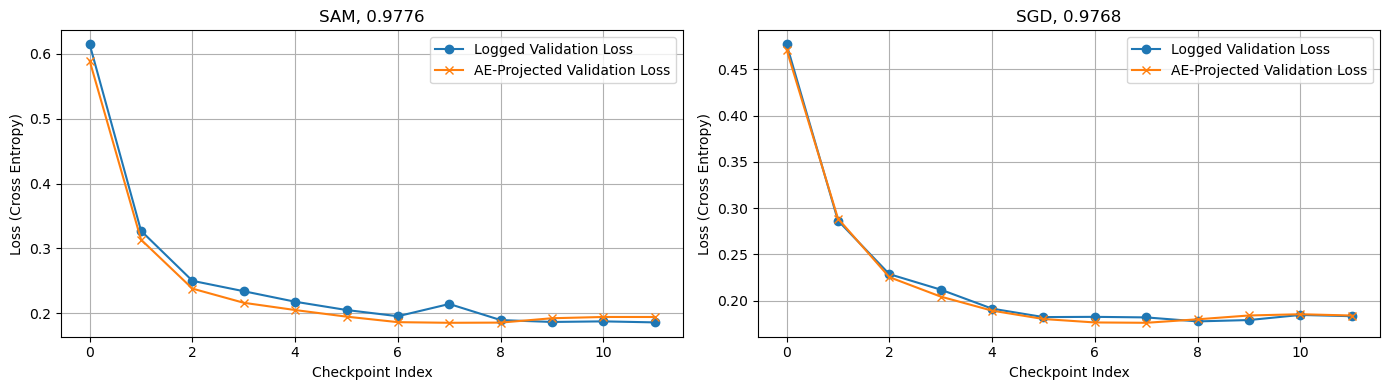

In [34]:
import matplotlib.pyplot as plt

cols = 2
rows = int(np.ceil(num_chunks / cols))

fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 4), squeeze=False)

for i in range(num_chunks):
    r, c = divmod(i, cols)
    ax = axes[r, c]

    ax.plot(real_losses[i], label='Logged Validation Loss', marker='o')
    ax.plot(tr_losses[i], label='AE-Projected Validation Loss', marker='x')

    ax.set_title(titles[i])
    ax.set_xlabel('Checkpoint Index')
    ax.set_ylabel('Loss (Cross Entropy)')
    ax.grid(True)
    ax.legend()

# Hide unused subplots (if odd number of runs)
for j in range(num_chunks, rows * cols):
    r, c = divmod(j, cols)
    fig.delaxes(axes[r, c])

plt.tight_layout()
plt.show()

In [35]:
# Generate grid in latent space
from helper.neuro_viz import generate_latent_grid, compute_grid_losses, compute_grid_losses_batched
xx, yy, grid_coords = generate_latent_grid(
    min_map=-1.1, max_map=1.1,
    xnum=25, # 3 - 25
    device=device
)

grid_losses = compute_grid_losses_batched(
    grid_coords,
    transform,
    ae_model,
    model,
    loss_obj,
    loss_name,
    whichloss,
    device,
    bn_recal_batches=30,
)

# Reshape to grid
grid_losses = grid_losses.view(xx.shape)

Computing grid losses: 100%|██████████| 6/6 [30:47<00:00, 307.87s/it]


In [36]:
print(grid_losses.min().item(), grid_losses.max().item())

0.16163119673728943 2.303910255432129


In [37]:
rec_grid_models = ae_model.decoder(grid_coords)
rec_grid_models = rec_grid_models*transform.std.to(device) + transform.mean.to(device)

If CUDA out of memory

In [38]:
def decode_grid_in_batches(ae_model, grid_coords, transform, device, batch_size=32):
    ae_model.eval()
    std = transform.std.to(device)
    mean = transform.mean.to(device)
    chunks = []

    with torch.no_grad():
        for i in range(0, grid_coords.size(0), batch_size):
            coords = grid_coords[i : i + batch_size].to(device)      # [B,2]
            rec = ae_model.decoder(coords)                            # [B, D]
            rec = rec * std + mean                                    # [B, D]
            chunks.append(rec.cpu())     # move back to CPU immediately
            del coords, rec
            torch.cuda.empty_cache()     # free any cached GPU memory

    return torch.cat(chunks, dim=0)      # [N, D]

In [39]:
# rec_grid_models = decode_grid_in_batches(
#     ae_model, grid_coords, transform, device, batch_size=16
# )

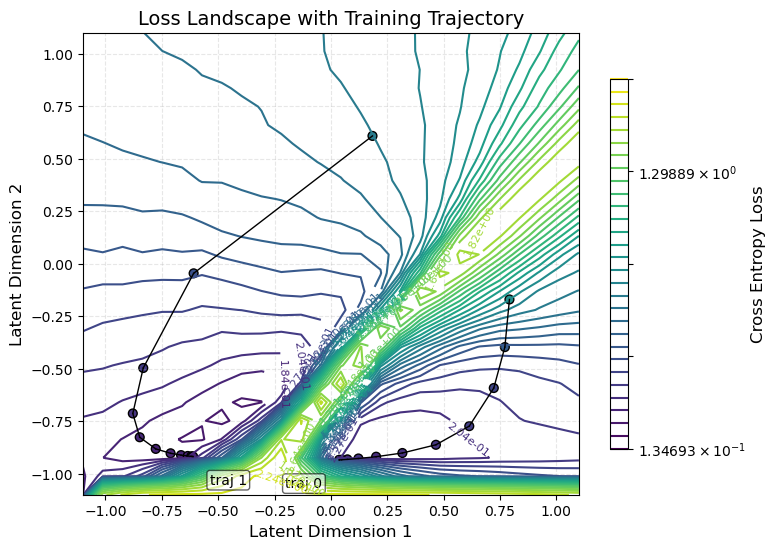

In [40]:
from helper.neuro_viz import plot_loss_landscape

fig = plot_loss_landscape(
    xx, yy,
    grid_losses,
    real_losses, # real_losses or tr_losses
    tr_coordinates,
    rec_grid_models=rec_grid_models,
    draw_density=False,
    filled_contours=False
)

In [41]:
# Save to PDF
os.makedirs('plots', exist_ok=True)
fig.savefig(f'plots/loss_landscape_{vis_id}.pdf', dpi=300, bbox_inches='tight', format='pdf')
print(f"Saved PDF to plots/loss_landscape_{vis_id}.pdf")

Saved PDF to plots/loss_landscape_run-0011-CNN x run-0012-CNN.pdf


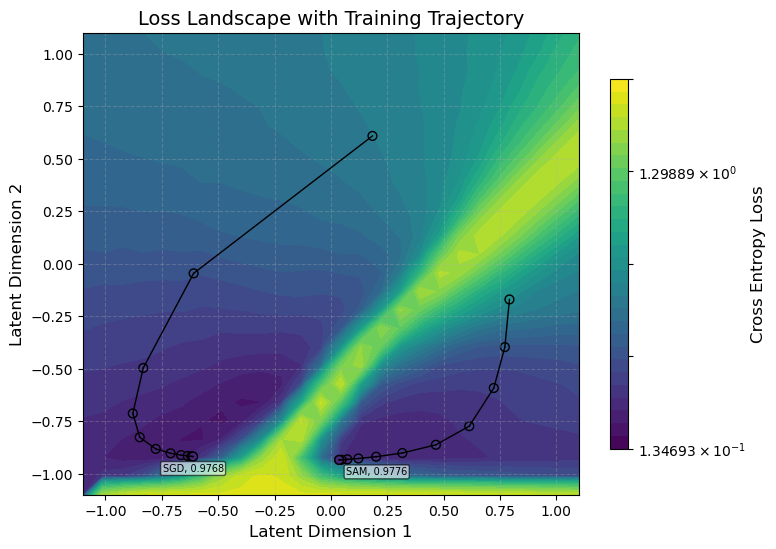

In [67]:
fig = plot_loss_landscape(
    xx, yy,
    grid_losses,
    real_losses, # real_losses or tr_losses
    tr_coordinates,
    rec_grid_models=rec_grid_models,
    draw_density=False,
    filled_contours=True,
    trajectory_labels=titles,            # NEW: list of strs, one per trajectory - ['Test 1', 'Test 2', 'Test 3', 'Test 4'],
    label_positions=[('left', 'top'), ('center', 'top'), ('right', 'bottom'), ('right', 'top'), ('left', 'center'), ('center', 'bottom')], # ('left'|'center'|'right', 'top'|'center'|'bottom')
)

In [68]:
os.makedirs('plots', exist_ok=True)
fig.savefig(f'plots/loss_landscape_{vis_id}.pdf', dpi=300, bbox_inches='tight', format='pdf')
print(f"Saved PDF to plots/loss_landscape_{vis_id}.pdf")

Saved PDF to plots/loss_landscape_run-0011-CNN x run-0012-CNN.pdf


In [54]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

def plot_density_only(xx, yy, rec_grid_models, cmap="viridis"):
    """
    Plot only the density (no loss landscape, no trajectories).
    Density is computed via NeuroVisualizer utils.
    """
    X = xx.cpu().numpy()
    Y = yy.cpu().numpy()

    try:
        from NeuroVisualizer.neuro_aux.utils import get_density

        # Compute density
        density = get_density(rec_grid_models.detach().cpu().numpy(), type='inverse', p=2)
        density = density.reshape(xx.shape)

        # Levels for gradient contour
        density_levels = np.logspace(
            np.log10(max(density.min(), 1e-3)),
            np.log10(density.max()),
            50  # more levels = smoother Farbverlauf
        )

        fig, ax = plt.subplots(figsize=(7, 6))

        # Filled contours with gradient
        CS = ax.contourf(
            X, Y, density,
            levels=density_levels,
            cmap=cmap,
            norm=LogNorm(vmin=density.min(), vmax=density.max())
        )

        # Colorbar
        cbar = plt.colorbar(CS, ax=ax, shrink=0.8)
        cbar.set_label("Density", fontsize=12)

        ax.set_title("Density Plot", fontsize=14)
        ax.set_xlabel("Latent Dimension 1", fontsize=12)
        ax.set_ylabel("Latent Dimension 2", fontsize=12)

        return fig

    except Exception as e:
        print("Density plot skipped:", e)
        return None

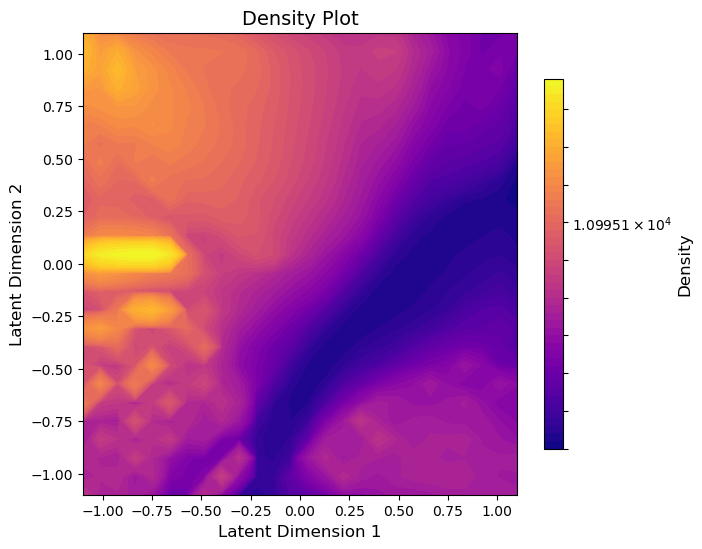

In [58]:
fig_density = plot_density_only(xx, yy, rec_grid_models, cmap="plasma")

In [59]:
os.makedirs('plots', exist_ok=True)
fig_density.savefig(f'plots/loss_landscape_{vis_id}_density.pdf', dpi=300, bbox_inches='tight', format='pdf')
print(f"Saved PDF to plots/loss_landscape_{vis_id}_density.pdf")

Saved PDF to plots/loss_landscape_run-0011-CNN x run-0012-CNN_density.pdf
